# Učitavanje potrebnih biblioteka i mamograma

## Učitavanje biblioteka

In [1]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.5 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import cv2
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

## Validacija i učitavanja mamograma

In [9]:
putanja = "/content/drive/MyDrive/zadatak"

In [10]:
def validiranje(slike):
    for i, slika in enumerate(slike):
        if slika is None or len(slika.shape) != 2:
            print(f"Slika {i} nije ucitana ili nema odgovarajuce dimenzije")

        min_vrednost, max_vrednost = np.min(slika), np.max(slika)
        if min_vrednost < 0 or max_vrednost > 65535:
            print(f"Slika {i} ima neispravan raspon piksela: {min_vrednost} - {max_vrednost}")

In [11]:
def ucitavanje_slika(putanja_do_foldera):
    slike = []
    file_names = []
    for file_name in os.listdir(putanja_do_foldera):
        if file_name.endswith(".dcm"):
            fajl = os.path.join(putanja_do_foldera, file_name)
            try:
                dicom_slika = pydicom.dcmread(fajl)
                img = dicom_slika.pixel_array
                slike.append(img)
                file_names.append(file_name)

            except Exception as e:
                print(f"Greska {file_name}: {e}")
    return slike, file_names

slike, file_names = ucitavanje_slika(putanja)
print("Slike su uctiane")
validiranje(slike)

Slike su uctiane


# Preprocesing

In [12]:
def primena_clahe(slika):
    slika = cv2.normalize(slika, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
    slika = slika.astype(np.uint8)
    slika = cv2.medianBlur(slika, 5)
    clahe = cv2.createCLAHE(clipLimit = 1.0, tileGridSize = (16, 16))
    slika = clahe.apply(slika)
    return slika

In [13]:
def preprocesiranje(slika, target_size = (512, 512)):
    slika = primena_clahe(slika)
    slika = cv2.resize(slika, target_size)
    return slika

preprocesirane_slike = [preprocesiranje(img) for img in slike]

## Histogrami

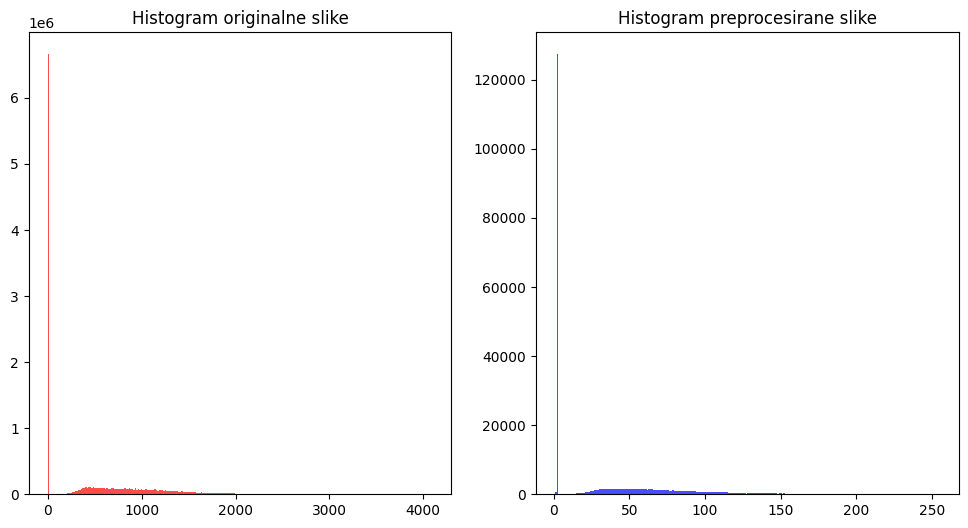

In [14]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.hist(slike[0].ravel(), bins = 256, color = 'red', alpha = 0.7)
plt.title("Histogram originalne slike")

plt.subplot(1, 2, 2)
plt.hist(preprocesirane_slike[0].ravel(), bins = 256, color = 'blue', alpha = 0.7)
plt.title("Histogram preprocesirane slike")
plt.show()

Na levom histogramu prikazana je distribucija intenziteta piksela originalnih DICOM slika. Većina piksela ima intenzitet blizu nule, što može značiti da su slike u možda tamne ili imaju nizak kontrast.

Na desnom histogramu prikazana je distribucija intenziteta piksela nakon preprocesiranja. Intenzitet je redistribuiran u širem opsegu (0–255), što znači da je kontrast poboljšan. Ova redistribucija bi trebalo da omogući modelima mašinskog učenja da bolje identifikuju važne karakteristike na slikama. Redistribucija intenziteta potvrđuje da je algoritam uspešno poboljšao kontrast.


# Klasifikacija

## Priprema skupa podataka

In [15]:
X = np.array(preprocesirane_slike)

X = X[..., np.newaxis]
X = np.repeat(X, 3, axis=-1)
print("Skup podataka: ", X.shape)

Skup podataka:  (10, 512, 512, 3)


## Učitavanje pretreniranog modela

In [8]:
model_path = '/content/drive/MyDrive/model_vgg16.keras'
model = tf.keras.models.load_model(model_path)

In [7]:
model_path2 = '/content/drive/MyDrive/model_vgg16_birads.keras'
model2 = tf.keras.models.load_model(model_path2)

## Predikcija

In [16]:
predikcije = model.predict(X)
klase_0_1 = np.argmax(predikcije, axis=1)
klase = ["nesuspektna" if kls == 0 else "suspektna" for kls in klase_0_1]

output_df = pd.DataFrame({
    "Naziv slike": file_names,
    "Predikcija": klase})

output_putanja = '/content/drive/MyDrive/predikcije.csv'
output_df.to_csv(output_putanja, index=False)
print(f"Predikcije su sacuvane")


1/1 [==============================] - 11s 11s/step
Predikcije su sacuvane


In [17]:
predikcije = model.predict(X)
klase_0_4 = np.argmax(predikcije, axis=1)
klase = ["Bi-rads 1", "Bi-rads 2", "Bi-rads 3", "Bi-rads 4", "Bi-rads 5"]
predikcije = [klase[kls] for kls in klase_0_4]

output_df = pd.DataFrame({
    "Naziv slike": file_names,
    "Predikcija": predikcije})

output_putanja = '/content/drive/MyDrive/predikcije_birads.csv'
output_df.to_csv(output_putanja, index=False)
print(f"Predikcije su sacuvane")

1/1 [==============================] - 11s 11s/step
Predikcije su sacuvane
